In [59]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt 

from art.attacks import FastGradientMethod, DeepFool, ProjectedGradientDescent, CarliniL2Method
from art.classifiers import KerasClassifier
from art.utils import load_mnist

In [60]:
(x_train, y_train), (x_test, y_test), min_pixel_value, max_pixel_value = load_mnist()
batch_size = 128
num_classes = 10
epochs = 3

# input image dimensions
img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

### Benign Examples

#### Artificial Neural Network 

In [61]:
ann_model = Sequential()  
    
ann_model.add(Dense(100, activation='relu', input_dim=784))
ann_model.add(Dense(200, activation='relu')) 
ann_model.add(Dense(200, activation='relu')) 
ann_model.add(Dense(200, activation='relu')) 
ann_model.add(Dense(100, activation='relu')) 
ann_model.add(Dense(10, activation='softmax'))
  
ann_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
ann_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_20 (Dense)             (None, 200)               20200     
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_22 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_23 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 200,210
Trainable params: 200,210
Non-trainable params: 0
_________________________________________________________________


In [62]:
x_train_ann = x_train.reshape(x_train.shape[0], img_rows* img_cols)
x_test_ann = x_test.reshape(x_test.shape[0], img_rows* img_cols)

In [63]:
ann_classifier = KerasClassifier(model=ann_model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
ann_classifier.fit(x_train_ann, y_train, batch_size=batch_size, nb_epochs=epochs)

Epoch 1/3
469/468 [==============================] - 16s 35ms/step - loss: 1.7101 - acc: 0.5142
Epoch 2/3
469/468 [==============================] - 6s 13ms/step - loss: 0.5093 - acc: 0.8521
Epoch 3/3
469/468 [==============================] - 6s 13ms/step - loss: 0.3540 - acc: 0.8985


In [64]:
predictions = ann_classifier.predict(x_test_ann)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
print('Accuracy on benign test examples for ANN: {}%'.format(accuracy * 100))

Accuracy on benign test examples for ANN: 90.75999999999999%


#### Convolutional Neural Network 

In [65]:
cnn_model = Sequential()
    
cnn_model.add(Conv2D(6, kernel_size= (3, 3), activation='relu', input_shape=input_shape)) 
cnn_model.add(Conv2D(10, kernel_size= (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())

cnn_model.add(Dense(100, activation='relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(10, activation='softmax'))

cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01), metrics=['accuracy'])
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 6)         60        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 10)        550       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 10)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1440)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 100)               144100    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
__________

In [66]:
cnn_classifier = KerasClassifier(model=cnn_model, clip_values=(min_pixel_value, max_pixel_value), use_logits=False)
cnn_classifier.fit(x_train, y_train, batch_size=batch_size, nb_epochs=epochs)

Epoch 1/3
469/468 [==============================] - 85s 181ms/step - loss: 1.4521 - acc: 0.4999
Epoch 2/3
469/468 [==============================] - 80s 171ms/step - loss: 0.6424 - acc: 0.7922
Epoch 3/3
469/468 [==============================] - 93s 199ms/step - loss: 0.5301 - acc: 0.83242s - loss: 0.5307


### Adversarial Examples

#### Artificial Neural Network 

In [67]:
ann_attack_1 = FastGradientMethod(classifier = ann_classifier)
ann_attack_2 = DeepFool(classifier = ann_classifier)
ann_attack_3 = ProjectedGradientDescent(classifier = ann_classifier)
ann_attack_4 = CarliniL2Method(classifier = ann_classifier)
x_adv_1 = ann_attack_1.generate(x=x_test_ann[0:1])
x_adv_2 = ann_attack_2.generate(x=x_test_ann[0:1])
x_adv_3 = ann_attack_3.generate(x=x_test_ann[0:1])
x_adv_4 = ann_attack_4.generate(x=x_test_ann[0:1])

Original Sample :


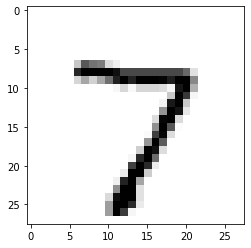

Adversarial Sample - FastGradientMethod:


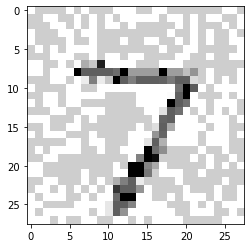

Adversarial Sample - DeepFool:


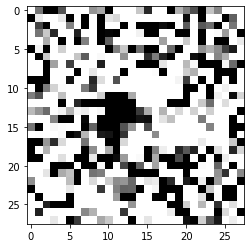

Adversarial Sample - ProjectedGradientDescent:


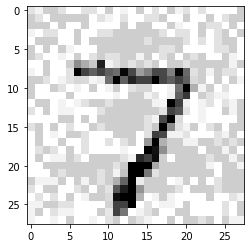

Adversarial Sample - CarliniL2Method:


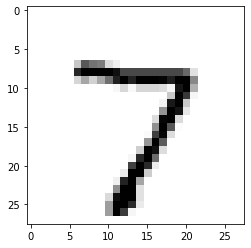

In [68]:
print("Original Sample :")
plt.imshow(x_test_ann[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - FastGradientMethod:")
plt.imshow(x_adv_1[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - DeepFool:")
plt.imshow(x_adv_2[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - ProjectedGradientDescent:")
plt.imshow(x_adv_3[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - CarliniL2Method:")
plt.imshow(x_adv_4[0].reshape((28,28)), cmap='Greys')
plt.show()

#### Convolutional Neural Network 

In [ ]:
cnn_attack_1 = FastGradientMethod(classifier = cnn_classifier)
cnn_attack_2 = DeepFool(classifier = cnn_classifier)
cnn_attack_3 = ProjectedGradientDescent(classifier = cnn_classifier)
cnn_attack_4 = CarliniL2Method(classifier = cnn_classifier)
x_adv_5 = cnn_attack_1.generate(x=x_test_ann[0:1])
x_adv_6 = cnn_attack_2.generate(x=x_test_ann[0:1])
x_adv_7 = cnn_attack_3.generate(x=x_test_ann[0:1])
x_adv_8 = cnn_attack_4.generate(x=x_test_ann[0:1])

In [ ]:
print("Original Sample :")
plt.imshow(x_test_ann[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - FastGradientMethod:")
plt.imshow(x_adv_5[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - DeepFool:")
plt.imshow(x_adv_6[0].reshape((28,28)), cmap='Greys')
plt.show()
print("Adversarial Sample - ProjectedGradientDescent:")
plt.imshow(x_adv_7[0].reshape((28,28)), cmap='Greys')
plt.show(
print("Adversarial Sample - CarliniL2Method:")
plt.imshow(x_adv_8[0].reshape((28,28)), cmap='Greys')
plt.show()

In [ ]:
# Step 7: Evaluate the ART classifier on adversarial test examples
k = 2500
x_test_adv_1 = ann_attack_1.generate(x=x_test_ann[0:k])
x_test_adv_2 = ann_attack_2.generate(x=x_test_ann[k:2*k])
x_test_adv_3 = ann_attack_3.generate(x=x_test_ann[2*k:3*k])
x_test_adv_4 = ann_attack_4.generate(x=x_test_ann[3*k:4*k])

In [ ]:
x_test_adv = np.concatenate((x_test_adv_1, x_test_adv_2, x_test_adv_3, x_test_adv_4), axis=0)
predictions = ann_classifier.predict(x_test_adv)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test[0:4*k], axis=1)) / len(y_test[0:4*k])
print('Accuracy on adversarial test examples for ANN: {}%'.format(accuracy * 100))